# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [ ]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
#settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: C:\Users\klara\Universidade\Year 2\Scalable ML and DL\Lab1\mlfs-book
HopsworksSettings initialized!


In [2]:
import datetime
from datetime import timedelta
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [41]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
before_yesterday = today - datetime.timedelta(days = 2)
before_2_yesterday = today - datetime.timedelta(days = 3)

print(tomorrow, yesterday, before_yesterday, before_2_yesterday)

2025-11-13 17:33:24.463217 2025-11-11 17:33:24.463217 2025-11-10 17:33:24.463217 2025-11-09 17:33:24.463217


In [4]:
AQICN_API_KEY = settings.AQICN_API_KEY.get_secret_value() 
aqicn_url = settings.AQICN_URL
country = settings.AQICN_COUNTRY
city = settings.AQICN_CITY
street = settings.AQICN_STREET

print(f"Found AQICN_API_KEY: {AQICN_API_KEY}")


secrets = hopsworks.get_secrets_api()
# Replace any existing secret with the new value
secret = secrets.get_secret("AQICN_API_KEY")
print(secret)
if secret is not None:
    secret.delete()
    print("Replacing existing AQICN_API_KEY")

secrets.create_secret("AQICN_API_KEY", AQICN_API_KEY)

Found AQICN_API_KEY: 40d2e420b629b2dc3978ff2dd4de38d7f9ac9454


NoHopsworksConnectionError: Connection is not active. Needs to be connected for feature store operations.

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [5]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-12 17:14:51,434 INFO: Initializing external client
2025-11-12 17:14:51,438 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-12 17:14:52,827 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-12 17:14:54,005 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279151


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [6]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_with_lags",
    version=3,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-12 17:14:59,381 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/508757 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110913 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/24714 elapsed<00:00 remaining<?

In [7]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='6.6810946E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [8]:
aq_fg = fs.get_feature_group(
    name='air_quality_lagged',
    version=2,
)

weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data=batch_data.sort_values(by="date", ascending=True)
batch_data=batch_data.reset_index(drop=True)
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.83s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-13 00:00:00+00:00,17.75,0.0,1.484318,75.963730,rome
1,2025-11-14 00:00:00+00:00,18.15,0.0,2.545584,81.869987,rome
2,2025-11-15 00:00:00+00:00,19.40,0.0,13.849476,171.027451,rome
3,2025-11-16 00:00:00+00:00,21.00,0.0,17.727943,167.092590,rome
4,2025-11-17 00:00:00+00:00,20.65,0.6,17.208603,217.349426,rome


In [50]:
aq_today_df = util.get_pm25(aqicn_url, country, city, street, today, AQICN_API_KEY)
aq_yesterday_df = util.get_pm25(aqicn_url, country, city, street, yesterday, AQICN_API_KEY)
aq_before_yesterday_df = util.get_pm25(aqicn_url, country, city, street, before_yesterday, AQICN_API_KEY)
aq_before_2_yesterday_df = util.get_pm25(aqicn_url, country, city, street, before_2_yesterday, AQICN_API_KEY)

print(aq_before_2_yesterday_df)
print(aq_before_yesterday_df)
print(aq_yesterday_df)

   pm25 country  city      street                       date  \
0  18.0   italy  rome  via-clelia 2025-11-09 17:33:24.463217   

                                  url  
0  https://api.waqi.info/feed/A98194/  
   pm25 country  city      street                       date  \
0  18.0   italy  rome  via-clelia 2025-11-10 17:33:24.463217   

                                  url  
0  https://api.waqi.info/feed/A98194/  
   pm25 country  city      street                       date  \
0  18.0   italy  rome  via-clelia 2025-11-11 17:33:24.463217   

                                  url  
0  https://api.waqi.info/feed/A98194/  


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

#### Auto regresive model

In [44]:
# Set the lag values
lag_1 = aq_yesterday_df.iloc[0]['pm25'] 
lag_2 = aq_before_yesterday_df.iloc[0]['pm25'] 
lag_3 = aq_before_2_yesterday_df.iloc[0]['pm25']

print(lag_3)

# Grab the first row for predictions
weather_tomorrow = batch_data.head(1)

batch_data.loc[0, 'lag_1'] = lag_1
batch_data.loc[0, 'lag_2'] = lag_2
batch_data.loc[0, 'lag_3'] = lag_3
batch_data

15.0


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag_1,lag_2,lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-13 00:00:00+00:00,17.75,0.0,1.484318,75.963730,rome,15.000000,15.000000,15.000000,13.736540,via-clelia,italy,1
1,2025-11-14 00:00:00+00:00,18.15,0.0,2.545584,81.869987,rome,13.736540,20.000000,20.000000,16.325418,via-clelia,italy,2
2,2025-11-15 00:00:00+00:00,19.40,0.0,13.849476,171.027451,rome,16.325418,13.736540,20.000000,14.593745,via-clelia,italy,3
3,2025-11-16 00:00:00+00:00,21.00,0.0,17.727943,167.092590,rome,14.593745,16.325418,13.736540,15.206627,via-clelia,italy,4
4,2025-11-17 00:00:00+00:00,20.65,0.6,17.208603,217.349426,rome,15.206627,14.593745,16.325418,11.936040,via-clelia,italy,5


In [45]:
# Copy batch_data into a new dataframe
weather_forecast = batch_data.sort_values(by='date').copy()
# Set the lag values
lag_1 = aq_yesterday_df.iloc[0]['pm25'] 
lag_2 = aq_before_yesterday_df.iloc[0]['pm25'] 
lag_3 = aq_before_2_yesterday_df.iloc[0]['pm25']

# List to save predictions
predictions = []

# Features columns
feature_columns = [
            'lag_1', 
            'lag_2', 
            'lag_3', 
            'temperature_2m_mean',
            'precipitation_sum', 
            'wind_speed_10m_max', 
            'wind_direction_10m_dominant']

for i in range(len(batch_data)):
    # Assign lags to each day
    batch_data.loc[i, 'lag_1'] = lag_1
    batch_data.loc[i, 'lag_2'] = lag_2
    batch_data.loc[i, 'lag_3'] = lag_3

    X_row = batch_data.loc[[i], feature_columns]
    pm25_pred = float(retrieved_xgboost_model.predict(X_row)[0])

    # Save prediction
    batch_data.loc[i, 'predicted_pm25'] = pm25_pred

    # Update lags
    lag_3, lag_2, lag_1 = lag_2, lag_1, pm25_pred

In [46]:
batch_data['predicted_pm25'] = batch_data['predicted_pm25'].astype('float32')
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag_1,lag_2,lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-13 00:00:00+00:00,17.75,0.0,1.484318,75.963730,rome,15.000000,15.000000,15.000000,13.855805,via-clelia,italy,1
1,2025-11-14 00:00:00+00:00,18.15,0.0,2.545584,81.869987,rome,13.855805,15.000000,15.000000,14.509908,via-clelia,italy,2
2,2025-11-15 00:00:00+00:00,19.40,0.0,13.849476,171.027451,rome,14.509908,13.855805,15.000000,13.074773,via-clelia,italy,3
3,2025-11-16 00:00:00+00:00,21.00,0.0,17.727943,167.092590,rome,13.074773,14.509908,13.855805,10.982627,via-clelia,italy,4
4,2025-11-17 00:00:00+00:00,20.65,0.6,17.208603,217.349426,rome,10.982627,13.074773,14.509908,5.654710,via-clelia,italy,5


In [13]:
# Feature columns
'''
feature_columns = [
            'lag_1', 
            'lag_2', 
            'lag_3', 
            'temperature_2m_mean',
            'precipitation_sum', 
            'wind_speed_10m_max', 
            'wind_direction_10m_dominant'
        ]
        '''

"\nfeature_columns = [\n            'lag_1', \n            'lag_2', \n            'lag_3', \n            'temperature_2m_mean',\n            'precipitation_sum', \n            'wind_speed_10m_max', \n            'wind_direction_10m_dominant'\n        ]\n        "

In [14]:
# batch_data

In [15]:
# Make predictions
#batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(batch_data[feature_columns])
#batch_data

In [16]:
#Change this
# batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
# batch_data

In [17]:
#batch_data.info()

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [47]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag_1,lag_2,lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-13 00:00:00+00:00,17.75,0.0,1.484318,75.963730,rome,15.000000,15.000000,15.000000,13.855805,via-clelia,italy,1
1,2025-11-14 00:00:00+00:00,18.15,0.0,2.545584,81.869987,rome,13.855805,15.000000,15.000000,14.509908,via-clelia,italy,2
2,2025-11-15 00:00:00+00:00,19.40,0.0,13.849476,171.027451,rome,14.509908,13.855805,15.000000,13.074773,via-clelia,italy,3
3,2025-11-16 00:00:00+00:00,21.00,0.0,17.727943,167.092590,rome,13.074773,14.509908,13.855805,10.982627,via-clelia,italy,4
4,2025-11-17 00:00:00+00:00,20.65,0.6,17.208603,217.349426,rome,10.982627,13.074773,14.509908,5.654710,via-clelia,italy,5


In [30]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         5 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          5 non-null      float32                
 2   precipitation_sum            5 non-null      float32                
 3   wind_speed_10m_max           5 non-null      float32                
 4   wind_direction_10m_dominant  5 non-null      float32                
 5   city                         5 non-null      object                 
 6   lag_1                        5 non-null      float32                
 7   lag_2                        5 non-null      float32                
 8   lag_3                        5 non-null      float32                
 9   predicted_pm25               5 non-null      float32                
 10  street

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

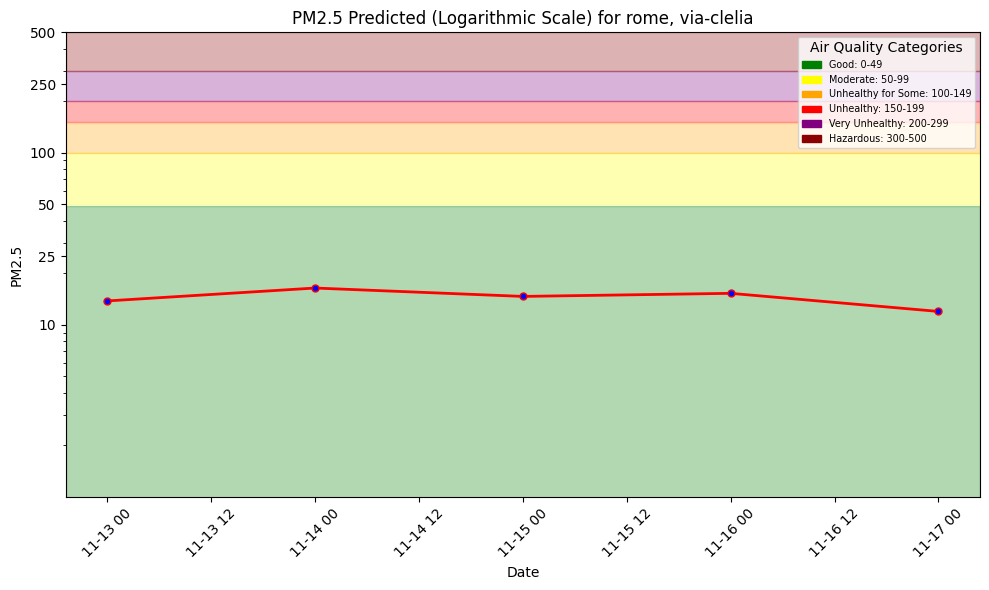

In [31]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [34]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions_lagged',
    description='Air Quality prediction monitoring with lags',
    version=6,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [35]:
monitor_fg.insert(batch_data, wait=True)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279151/fs/1265760/fg/1706358


Uploading Dataframe: 100.00% |██████████████████████████████| Rows 5/5 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_lagged_6_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279151/jobs/named/aq_predictions_lagged_6_offline_fg_materialization/executions
2025-11-12 17:22:31,778 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-12 17:23:10,081 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-12 17:25:15,128 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-12 17:25:15,306 INFO: Waiting for log aggregation to finish.
2025-11-12 17:25:40,886 INFO: Execution finished successfully.


(Job('aq_predictions_lagged_6_offline_fg_materialization', 'SPARK'), None)

In [36]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.40s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,lag_1,lag_2,lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-13 00:00:00+00:00,17.75,0.0,1.484318,75.96373,rome,20.0,20.0,20.0,13.73654,via-clelia,italy,1


In [48]:
air_quality_fg = fs.get_feature_group(name='air_quality_lagged', version=2)
air_quality_df = air_quality_fg.read()
air_quality_df
air_quality_df.sort_values(by=['date'])

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.72s) 


,date,pm25,lag_1,lag_2,lag_3,country,city,street,url
824,2020-02-04 00:00:00+00:00,8.93,9.65,18.75,31.559999,italy,rome,via-clelia,https://api.waqi.info/feed/A98194/
320,2020-02-05 00:00:00+00:00,1.25,8.93,9.65,18.750000,italy,rome,via-clelia,https://api.waqi.info/feed/A98194/
1782,2020-02-06 00:00:00+00:00,1.72,1.25,8.93,9.650000,italy,rome,via-clelia,https://api.waqi.info/feed/A98194/
1022,2020-02-07 00:00:00+00:00,4.83,1.72,1.25,8.930000,italy,rome,via-clelia,https://api.waqi.info/feed/A98194/
1146,2020-02-08 00:00:00+00:00,15.58,4.83,1.72,1.250000,italy,rome,via-clelia,https://api.waqi.info/feed/A98194/
...,...,...,...,...,...,...,...,...,...
623,2025-11-04 00:00:00+00:00,1.63,3.20,6.60,8.020000,italy,rome,via-clelia,https://api.waqi.info/feed/A98194/
51,2025-11-05 00:00:00+00:00,3.83,1.63,3.20,6.600000,italy,rome,via-clelia,https://api.waqi.info/feed/A98194/
775,2025-11-06 00:00:00+00:00,7.93,3.83,1.63,3.200000,italy,rome,via-clelia,https://api.waqi.info/feed/A98194/
2072,2025-11-11 00:00:00+00:00,28.00,28.00,28.00,28.000000,italy,rome,via-clelia,https://api.waqi.info/feed/A98194/


In [38]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.79s) 


Uploading Dataframe: 100.00% |██████████████████████████████| Rows 2/2 | Elapsed Time: 00:02 | Remaining Time: 00:00


Launching job: aq_predictions_lagged_6_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279151/jobs/named/aq_predictions_lagged_6_offline_fg_materialization/executions
2025-11-12 17:26:21,066 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-12 17:26:24,245 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-12 17:28:06,729 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-12 17:28:06,903 INFO: Waiting for log aggregation to finish.
2025-11-12 17:28:25,710 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25,street,country,lag_1,lag_2,lag_3,predicted_pm25,days_before_forecast_day
0,2025-11-11 00:00:00+00:00,17.150000,0.0,2.545584,8.130019,rome,28.0,via-clelia,italy,28.0,28.0,28.0,12.73272,1
1,2025-11-12 00:00:00+00:00,17.700001,0.0,1.609969,116.564987,rome,15.0,via-clelia,italy,12.0,12.0,12.0,15.02440,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

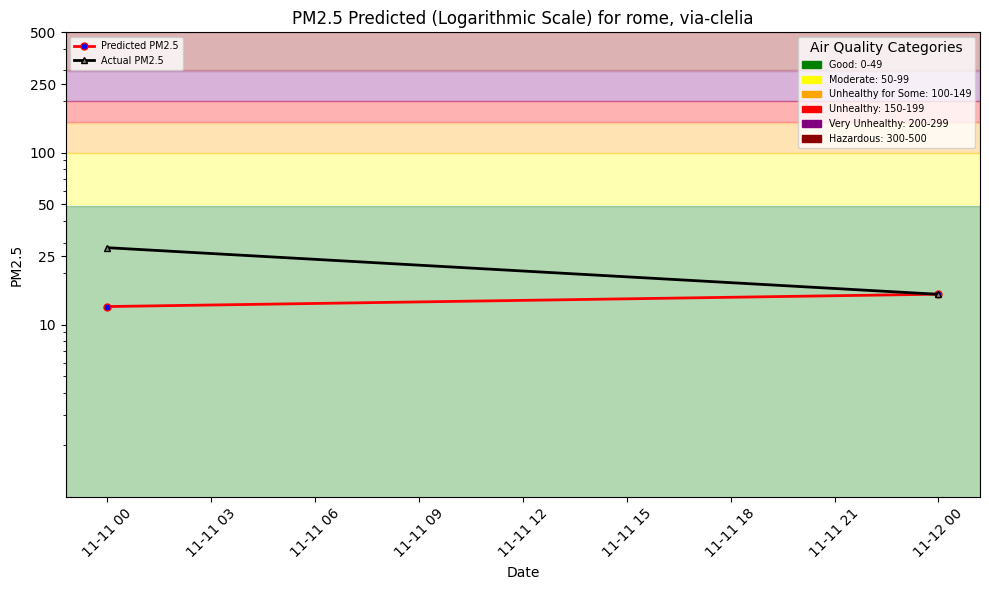

In [39]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [40]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading C:\Users\klara\Universidade\Year 2\Scalable ML and DL\Lab1\mlfs-book/docs/air-quality/assets/img/pm2…

Uploading C:\Users\klara\Universidade\Year 2\Scalable ML and DL\Lab1\mlfs-book/docs/air-quality/assets/img/pm2…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279151/settings/fb/path/Resources/airquality


---